In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# 1. Check if a GPU is available
# TensorFlow automatically uses the GPU if installed, but we can verify it here.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using device: GPU ({len(gpus)} available)")
    for gpu in gpus:
        print(f" - {gpu.name}")
else:
    print("Using device: CPU")

Using device: GPU (1 available)
 - /physical_device:GPU:0


In [16]:
# Load CIFAR10
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Split train/valid
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, train_size=0.8, random_state=42, shuffle=True
)

batch_size = 32

In [17]:
resize_layer = tf.keras.layers.Resizing(224, 224)
preprocess_fn = tf.keras.applications.resnet50.preprocess_input

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = resize_layer(image)
    image = preprocess_fn(image)
    return image, label


In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .shuffle(10000).map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)) \
    .map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [19]:
base = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base.trainable = False   # Freeze backbone for fast training

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)



Starting Training...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 108ms/step - accuracy: 0.8092 - loss: 0.5532 - val_accuracy: 0.8898 - val_loss: 0.3122
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 127s 102ms/step - accuracy: 0.9074 - loss: 0.2675 - val_accuracy: 0.8968 - val_loss: 0.2984
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 127s 101ms/step - accuracy: 0.9181 - loss: 0.2340 - val_accuracy: 0.9041 - val_loss: 0.2849
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 127s 102ms/step - accuracy: 0.9270 - loss: 0.2091 - val_accuracy: 0.9080 - val_loss: 0.2774
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 127s 101ms/step - accuracy: 0.9335 - loss: 0.1891 - val_accuracy: 0.9016 - val_loss: 0.2974
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 127s 101ms/step - accuracy: 0.9381 - loss: 0.1753 - val_accuracy: 0.9027 - val_loss: 0.2940
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.9423 - loss: 0.1620 - val_accuracy: 0.9027 - val_loss: 0.3093
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━

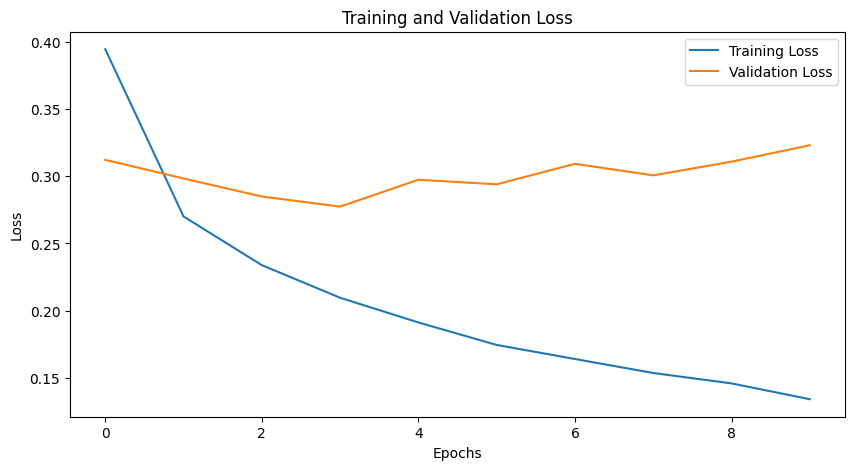

In [21]:
# 5. Train the Model
epochs = 10
print("\nStarting Training...")
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=valid_ds,
                    verbose=1)

# 6. Plotting
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# 7. Evaluation on Test Set
print("\nEvaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f'Accuracy on the test set: {100 * test_acc:.2f}%')


Evaluating on Test Set...
Accuracy on the test set: 89.88%
